[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rmartimarly/ImageRegistrationTutorial/blob/main/1Intro_image_registration.ipynb)

# Tutorial on Atlas based segmentation

Robert Martí robert.marti@udg.edu
University of Girona



A radiologist comes to your office and asks to help him for a very complicated problem: he has two images of the same patient and wants to find the changes the had happened in the two images: lesions, etc.

![Fixed](https://raw.githubusercontent.com/rmartimarly/ImageRegistrationTutorial/main/files/brain1.png "Fixed")
![Moving](https://raw.githubusercontent.com/rmartimarly/ImageRegistrationTutorial/main/files/brain2_lesion.png "Moving")


Could we measure how similar are two images?

### Import libraries

In [32]:
# !pip install numpy
# !pip install opencv-python
# !pip install pyplot

pip install SimpleITK


In [33]:
import numpy as np
import cv2

%matplotlib inline
# from matplotlib import pyplot as plt
# from matplotlib import cm
# from tensorflow.keras.utils import get_file
# import os

import os
import SimpleITK as sitk

### Loading images

In [105]:
# Import medical data - we are going to use the head and neck CT data to show the losses.
main_path = os.getcwd()

data_path = "files"
file_path1 = os.path.abspath(os.path.join(main_path,data_path, "brain1.png"))
origin1 = "https://raw.githubusercontent.com/rmartimarly/ImageRegistrationTutorial/main/files/brain1.png"
file_path2 = os.path.abspath(os.path.join(main_path,data_path, "brain2_lesion.png"))
origin2 = "https://raw.githubusercontent.com/rmartimarly/ImageRegistrationTutorial/main/files/brain2_lesion.png"

if not os.path.exists(data_path):
    os.makedirs(os.path.join(main_path, data_path))

if os.path.exists(file_path1):
    os.remove(file_path1)   
if os.path.exists(file_path2):
    os.remove(file_path2)   
       
get_file(file_path1, origin1)
get_file(file_path2, origin2)

# print("Download sample images: %s." % file_path1)

65536/64955 [==============================] - 0s 1us/step


'/home/robert/src/regTutorial/files/brain2_lesion.png'

/home/robert/src/regTutorial/files/brain1.png
8-bit unsigned integer
(354, 353)
(354, 353)


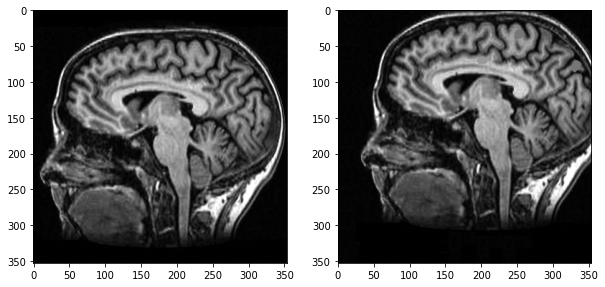

In [106]:
print(file_path1)
fixed_im = sitk.ReadImage(file_path1) 
moving_im = sitk.ReadImage(file_path2)

print(moving_im.GetPixelIDTypeAsString())
print(fixed_im.GetSize())
print(moving_im.GetSize())


fixed_a = sitk.GetArrayViewFromImage(fixed_im)
moving_a = sitk.GetArrayViewFromImage(moving_im)

f = plt.figure(figsize = (10,200))
f.add_subplot(1,2, 1)
plt.imshow(fixed_a, cmap='gray')    
f.add_subplot(1,2, 2)
plt.imshow(moving_a, cmap='gray')
plt.show(block=True)



### We analyse the difference image

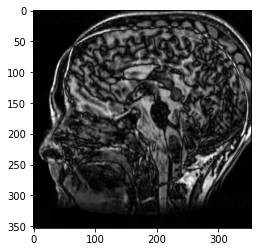

In [83]:
moving_r_im = sitk.Resample(moving_im, fixed_im, sitk.Transform(), sitk.sitkNearestNeighbor, 0.0, fixed_im.GetPixelID())
diff_fm = sitk.AbsoluteValueDifference(fixed_im,moving_r_im)

diff_a = sitk.GetArrayViewFromImage(diff_fm)
plt.imshow(diff_a, cmap='gray')
plt.show()


### Registration algorithm

In [ ]:
elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(fixed_im)
elastixImageFilter.SetMovingImage(moving_im)      

parameterMapVector = sitk.VectorOfParameterMap()
# parameterMapVector.append(sitk.GetDefaultParameterMap("affine"))
parameterMapVector.append(sitk.GetDefaultParameterMap("rigid"))

elastixImageFilter.SetParameterMap(parameterMapVector)
elastixImageFilter.SetParameter("MaximumNumberOfIterations",'5000') # max number of iterations was 255
elastixImageFilter.SetParameter("NumberOfSpatialSamples",'8192') # was 2048

elastixImageFilter.PrintParameterMap()

elastixImageFilter.Execute()  

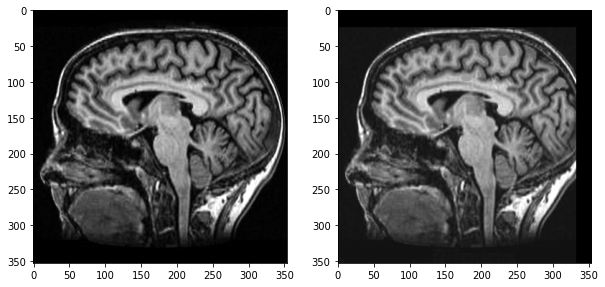

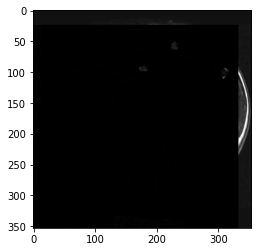

In [98]:
transf_moving = elastixImageFilter.GetResultImage()

f = plt.figure(figsize = (10,200))
f.add_subplot(1,2, 1)
plt.imshow(sitk.GetArrayViewFromImage(fixed_im), cmap='gray')    
f.add_subplot(1,2, 2)
plt.imshow(sitk.GetArrayViewFromImage(transf_moving), cmap='gray')
plt.show(block=True)

moving_r_im = sitk.Resample(transf_moving, fixed_im, sitk.Transform(), sitk.sitkNearestNeighbor, 0.0, fixed_im.GetPixelID())
diff_fm = sitk.AbsoluteValueDifference(fixed_im,moving_r_im)


plt.imshow(sitk.GetArrayViewFromImage(diff_fm), cmap='gray')
plt.show()


###  difference image

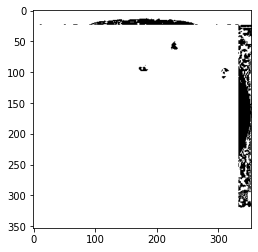

In [104]:
im_diff_a =sitk.GetArrayViewFromImage(diff_fm)
im_diff_a  = (im_diff_a >20) * 255

plt.imshow(255-im_diff_a , cmap='gray')
plt.show()
